## 0. Required Modules

The required modules imported below are listed in the requirements.txt file in the repository.

In [1]:
# import modules
from sklearn import datasets 
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd
import seaborn as sns
import math
import itertools


## 1. Exploratory Data Analysis 

In this coursework we are going to be working with the **Wine** dataset. This is a 178 sample dataset that categorises 3 different types of Italian wine using 13 different features. The code below loads the Wine dataset and selects a subset of features for you to work with.

In [2]:
# set matplotlib backend to inline
%matplotlib inline

# load data
wine=datasets.load_wine()
#print(wine.DESCR)

# this dataset has 13 features, we will only choose a subset of these
df_wine = pd.DataFrame(wine.data, columns = wine.feature_names )
selected_features = ['alcohol','flavanoids','color_intensity','ash']

# extract the data as numpy arrays of features, X, and target, y
X = df_wine[selected_features].values
y = wine.target

### 1.1. Visualising the data

The first task is to create a grid for the **Wine** dataset, with each off-diagonal subplot showing the interaction between two features, and each of the classes represented as a different colour. The on-diagonal subplots (representing a single feature) should show a distribution (or histogram) for that feature.     

Create a function that, given data X and labels y, plots this grid.  The function should be invoked something like this:
        
    myplotGrid(X,y,...)
    
where X is the training data and y are the labels. You can use an appropriate library to help you create the visualisation. You might want to code it yourself using matplotlib functions scatter and hist - however, this is not strictly necessary here, so try not spend too much time on this. 

In [3]:
def plot_grid(X, y, labels=None, hue_key=None):
    X = np.insert(X, len(X[0]), y, 1)
    labels = selected_features + [hue_key]
    
    data = pd.DataFrame(data=X, columns=labels)
    g = sns.PairGrid(data, hue=hue_key)
    g.map_diag(sns.kdeplot, fill=True)
    g.map_offdiag(sns.scatterplot)
    g.add_legend()

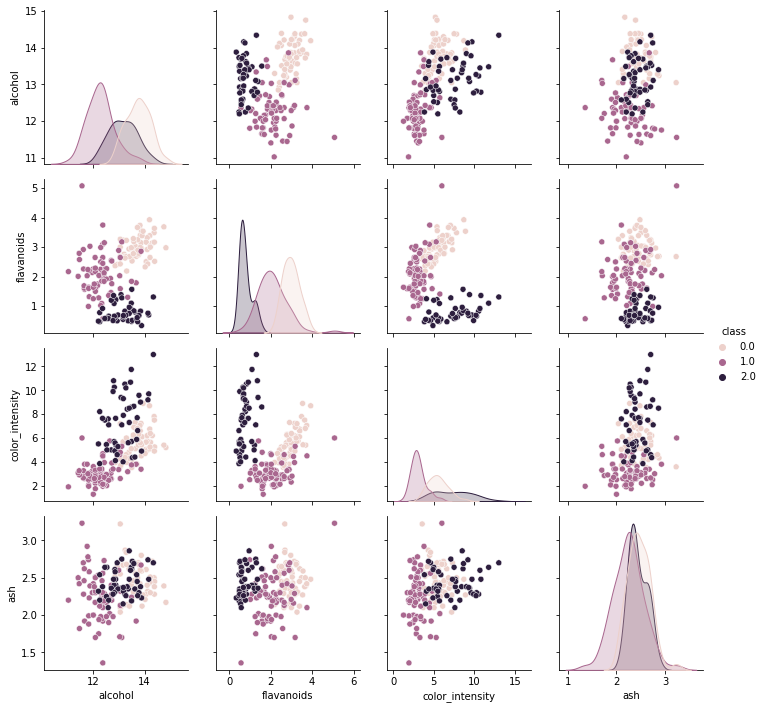

In [4]:
plot_grid(X, y, labels=selected_features, hue_key="class")

### 1.2. Exploratory Data Analysis under noise

When data are collected under real-world settings they usually contain some amount of noise that makes classification more challenging. In the cell below, invoke your exploratory data analysis function above on a noisy version of your data X.

Try to perturb your data with some Gaussian noise,

    # initialize random seed to replicate results over different runs
    mySeed = 12345 
    np.random.seed(mySeed) 
    XN=X+np.random.normal(0,0.6,X.shape)
    
and then invoke

    myplotGrid(XN,y)

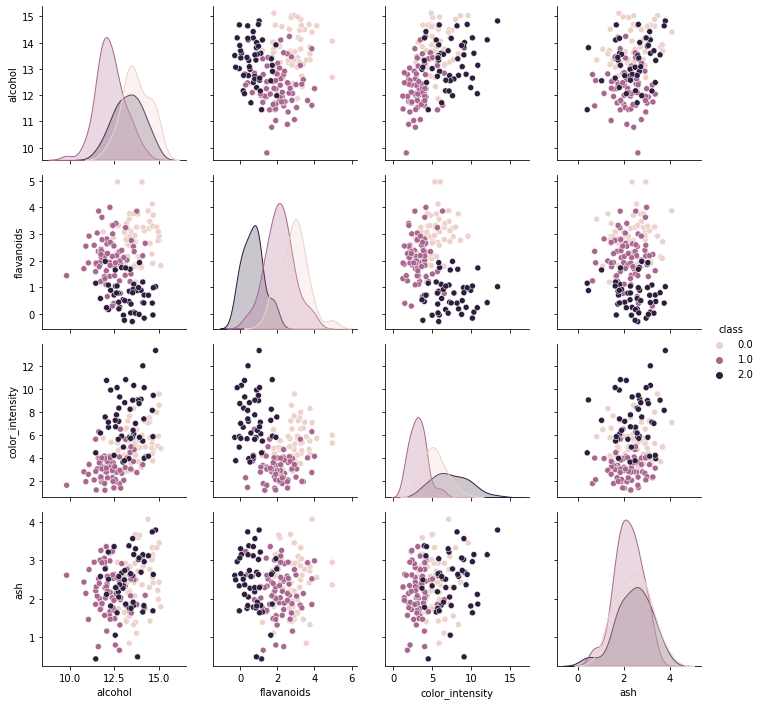

In [5]:
# Perturb data with noise to replicate real-world data
# Use a seed to replicate results over different runs
mySeed = 12 
np.random.seed(mySeed) 
XN=X+np.random.normal(0,0.6,X.shape)
plot_grid(XN, y, labels=selected_features, hue_key="class")

## 2. Implementing kNN 

In the cell below, develop your own code for performing k-Nearest Neighbour classification. Define a function that performs k-NN given a set of data.  Your function should be invoked similary to:

        y_ = mykNN(X,y,X_,options)
        
where X is your training data, y is your training outputs, X\_ are your testing data and y\_ are your predicted outputs for X\_.  The options argument (can be a list or a set of separate arguments depending on how you choose to implement the function) should at least contain the number of neighbours to consider as well as the distance function employed.

Hint: it helps to break the problem into various sub-problems, implemented as helper function. For example, you might want to implement separate function(s) for calculating the distances between two vectors. And another function that uncovers the nearest neighbour(s) to a given vector. 


### Helper functions for implementation of mykNN:

In [6]:

def split_data(data, split_ratio):
    
    """Split a list-type into two by a split ratio
    
    Parameters
    ----------
    data : sliceable object
    split_ratio : float (0 to 1)
    
    Returns
    -------
    list
        A list that contains the elements from 0 to the split_ratio as its first element, and the rest as its second element
    """

    total = len(data)
    
    # Calculate cutoff index. Clamp split ratio up to 1. Clamp result between 0 and data length
    cutoff_index = min(max(math.floor(total * min(split_ratio, 1)), 0), len(data))
    
    # Return sliced lists
    return [np.array(data[0:cutoff_index]), np.array(data[cutoff_index:])]
    

def euclidean_distance(p1, p2):
    
    """Computes Euclidean distance between two points
    
    Parameters
    ----------
    p1 : array-like
    p2 : array-like
    
    Returns
    -------
    float
        The Euclidean distance between both points
    """
    
    distance = 0.0
    for i in range(len(p1)):
        squared_diff = (p1[i] - p2[i])**2
        distance += squared_diff
    return math.sqrt(distance)


def manhattan_distance(p1, p2):
    
    """Computes Manhattan distance between two points
    
    Parameters
    ----------
    p1 : array-like
    p2 : array-like
    
    Returns
    -------
    float
        The Manhattan distance between both points
    """
    
    zipped_points = zip(p1, p2)
    differences = [abs(v1 - v2) for v1, v2 in zipped_points]
    return sum(differences)


# A p_value = 1 is equal to the Manhattan distance,
# and p_value = 2 is equal to the Euclidean distance.
# Minkowski distance is a generalization of both and
# allows for more fine tuning of it by tweaking p_value.
def minkowski_distance(p1, p2, p_value):
    
    """Computes Minkowski distance between two points
    
    The Minkowski distance is a generalization of the
    Manhattan and Euclidean distances that takes an extra
    p_value parameter. A p_value = 1 is identical to the
    Manhattan distance, whereas a p_value = 2 is identical
    to the Euclidean distance. However, tweaking the values
    in-betweeen allows for more fine grain control for
    Machine Learning purposes
    
    Parameters
    ----------
    p1 : array-like
    p2 : array-like
    p_value : float, between 1 and 2
    
    Returns
    -------
    float
        The Minkowski distance between both points
    
    """
    
    # Clamp p_value to values between 1 and 2
    p_value = min(max(p_value, 1), 2)
    
    # Zip our vector points for easier processing
    zipped_points = zip(p1, p2)
    
    # Compute the squared difference of each component of our vector
    squared_differences = [math.pow(abs(v1 - v2), p_value) for v1, v2 in zipped_points]
    
    # Sum the squared differences together
    summed_differences = sum(squared_differences)
    
    # Compute our root p value
    root_value = 1 / p_value
    
    # Return the Minkowski distance by raising to the power of our root value
    return math.pow(summed_differences, root_value)


def distance(p1, p2, dist_type="euclidean"):
    
    """Computes chosen distance type between two points
    
    Parameters
    ----------
    p1 : array-like
    p2 : array-like
    dist_type : string or int or float
        "euclidean" or "manhattan", or a number between 1 and 2
        to return the minkowski distance using that as p value
    
    Returns
    -------
    float
        The distance between both points of the chosen type
    """
    
    if dist_type == "manhattan":
        return manhattan_distance(p1, p2)
    
    elif dist_type == "euclidean":
        return euclidean_distance(p1, p2)
    
    # If the dist_type is actually a number, then
    # run the minkowski distance with dist_type as p
    elif type(dist_type) == int or type(dist_type) == float:
        return minkowski_distance(p1, p2, dist_type)
    
    # If dist_value doesn't fall on any of the above, default to euclidean
    return euclidean_distance(p1, p2)

    
# Find the k nearest neighbours from a
# series of points in space to a given point
def k_nearest_neighbours(test_data_point, data_points, k, distance_type):
    
    """Finds the k nearest neighbours among data_points to the test_data_point
    
    Parameters
    ----------
    test_data_point : list of values
    data_points : two-dimensional array-like
    k : int
        Number of closest neighbours to return
    distance_type : string
        Either "euclidean" or "manhattan"
    
    Returns
    -------
    list
        A list of the closest data points to test_data_point among data_points
    """
    
    points = []
    
    # Clamp our number of neighbours to the length of our data
    k = min(k, len(data_points))
    
    # Find the distances from all points to our testing point
    for point in data_points:
        dist = distance(point["data"], test_data_point["data"], distance_type)
        point["distance"] = dist
        
        # Append a pair of the point itself and the distance it's at
        points.append(point)
    
    # Sort our pairs of point/distances by the distance they're at, ascendingly
    points.sort(key = lambda point: point["distance"])
    
    # Get the first k points of our distances point/distance pairs
    neighbours = [points[i] for i in range(k)]
    return neighbours


def pick_class_from_neighbours(neighbours):
    
    """Picks a class among a list of neighbours, either the most common, or breaking ties if any
    
    The tie breaking is made by averaging all distances to the test point for each class, then
    picking the class with the lowest average distance.
    
    Parameters
    ----------
    neighbours : list of dicts
    
        This list is the same one that is returned by the k_nearest_neighbours method above.
    
    Returns
    -------
    number
        The selected label of the given test_point
    """
    
    classes = [ n["class"] for n in neighbours ]
    unique_classes = np.unique(classes)
    max_class_occurrence = max(classes, key=classes.count)
    max_classes = []

    # Iterate through our unique classes, and add that
    # class to max_classes if it's got the highest occurrence
    for c in unique_classes:
        if classes.count(c) == max_class_occurrence:
            max_classes.append(c)

    if len(max_classes) == 1:
        # Classes aren't tied, so return the max one
        return max_classes[0]

    # Here, we've got a tie of neighbour class counts
    # Calculate the average distance of each of them
    lowest_avg_distance = math.inf
    closest_avg_class = None

    # Find the avg distance among the members of a class.
    # If it is lower than the lowest recorded so far, record it.
    for c in max_classes:
        class_neighbours = [ n for n in neighbours if n["class"] == c ]
        distances = [ n["distance"] for n in class_neighbours ]
        avg_distance = np.mean(distances)

        if avg_distance < lowest_avg_distance:
            lowest_avg_distance = avg_distance
            closest_avg_class = c

    # Finally, return the class with the lowest avg distance
    return c



def predict_class(test_point, train_data, k, distance_type):
    
    """Predicts the label of test_point by using the elements in train_data and k-nearest-neighbours calculated with chosen distance_type
    
    Parameters
    ----------
    test_point : list of values
    train_data : two-dimensional array-like
    k : int
        Number of closest neighbours to return
    distance_type : string
        Either "euclidean" or "manhattan"
    
    Returns
    -------
    number
        The predicted label of the given test_point
    """
    
    neighbours = k_nearest_neighbours(test_point, train_data, k, distance_type)
    
    # Return the most common class across neighbours
    classes = [item["class"] for item in neighbours]
    prediction = max(classes, key=classes.count)
    return prediction
    

### Implementation of mykNN using all of the above helper functions:

In [7]:


# mykNN code
def mykNN(X, y, X_, k=5, distance_type="euclidean"):
    
    """Predicts the labels of a split of the data in X
    
    k-Nearest-Neighbour algorithm to predict the labels of the provided split within the dataset X, 
    using the complementary split and the target labels y as training data. Algorithm is set to use
    a number of nearest neighbours for its predictions equal to k, and a distance algorithm of the
    type chosen in distance_type.
    
    Parameters
    ----------
    X : two-dimensional array-like
        The full dataset without labels
        
    y : list
        The list of labels with indexes matching the rows in X
        
    k : int
        Number of closest neighbours to calculate in the prediction
        
    distance_type : string
        Either "euclidean" or "manhattan"
    
    Returns
    -------
    list
        The list of predicted labels for the split test data
    """
    
    classified_train_data = [{ "data": X[i], "class": y[i] } for i in range(0, len(X))]
    test_data = [{ "data": X_[i] } for i in range(0, len(X_))]
    predicted_classes = []
    
    for test_item in test_data:
        predicted_class = predict_class(test_item, classified_train_data, k, distance_type)
        predicted_classes.append(predicted_class)
        
    return np.array(predicted_classes)



### Test run of mykNN() to ensure it's working correctly:

In [8]:
# Pick a random seed to create a permutation of our dataset
np.random.seed(seed=420)
perm_X = np.random.permutation(X)
np.random.seed(seed=420)
perm_y = np.random.permutation(y)

# Split the dataset into 80% training, 20% testing
train_data, test_data = split_data(perm_X, split_ratio=0.8)
train_classes, test_classes = split_data(perm_y, split_ratio=0.8)

# Run mykNN and get the predicted classes
predicted_classes = mykNN(train_data, train_classes, test_data, k=10, distance_type="manhattan")
print("Predicted classes:\t" + str(predicted_classes))

Predicted classes:	[1 1 0 2 1 0 0 1 0 0 1 0 1 1 1 1 2 0 0 0 1 2 2 0 2 2 1 2 0 2 1 0 0 2 0 2]


## 3. Classifier evaluation 

In the cell below, implement your own classifier evaluation code. This should include some way of calculating confusion matrices, as well as common metrics like accuracy. 

Write some additional code that lets you display the output of your confusion matrices in a useful and easy-to-read manner.

You might want to test your functions on some test data, and compare the results to the sklearn library versions. 


### Performance metrics functions to evaluate our classifier results:

In [9]:

def create_confusion_matrix(true_y, predicted_y):
    
    """Returns the confusion matrix of ground truths vs. predicted labels
    
    Parameters
    ----------
    true_y : list
        The ground truths, or true labels
        
    predicted_y : list
        The labels predicted by the classifier
    
    Returns
    -------
    np.ndarray
        A two-dimensional numpy array; the confusion matrix
    """
    
    nbr_of_classes = len(np.unique(true_y))
    
    # Create an empty 2d array of zeroes, with as many rows and columns as classes
    matrix = np.zeros((nbr_of_classes, nbr_of_classes), dtype=int)
    
    # Iterate through each result of the classifier
    for i in range(0, len(predicted_y)):
        # Access the matrix cell indicated by the true class number
        # and the predicted one, and add one result there
        matrix[true_y[i], predicted_y[i]] += 1
            
    return matrix


def classifier_accuracy(true_y, predicted_y):
    
    """Returns the accuracy of the results of a classifier
    
    Parameters
    ----------
    true_y : list
        The ground truths, or true labels
        
    predicted_y : list
        The labels predicted by the classifier
    
    Returns
    -------
    float
        The accuracy ratio or percentage (0 to 1)
    """
    
    # Get the number of correct predictions
    predicted = np.where(true_y == predicted_y, 1, 0)
    
    # Get the total number of elements
    total = len(true_y)
    
    # Return the correct predictions divided by the number of elements
    return sum(predicted) / total


def classifier_class_recall(confusion_matrix):
    
    """Returns the per-class recall rate of a confusion matrix
    
    Parameters
    ----------
    confusion_matrix : np.ndarray
        A two-dimensional, square array
    
    Returns
    -------
    list
        The list of recall rate per class (0 to 1 for each element)
    """
    
    # Create a zero array with as many elements as classes
    recall = np.zeros(len(confusion_matrix))
    
    # Iterate through each class
    for i in range(0, len(confusion_matrix)):
        # Get the diagonal (correct number of predicted values) of that class
        diagonal_value = confusion_matrix[i][i]
        
        # Get the number of items of that class in this data
        row_sum = sum(confusion_matrix[i])
        
        # Calculate the percentage of times it predicted that class correctly
        recall[i] = diagonal_value / row_sum
        
    return recall


def classifier_precision(confusion_matrix):
    
    """Returns the per-class precision rate of a confusion matrix
    
    Parameters
    ----------
    confusion_matrix : np.ndarray
        A two-dimensional, square array
    
    Returns
    -------
    list
        The list of precision rate per class (0 to 1 for each element)
    """
    
    # Create a zero array with as many elements as classes
    precision = np.zeros(len(confusion_matrix))
    
    # Iterate through each class
    for i in range(0, len(confusion_matrix)):
        # Get the diagonal (correct number of predicted values) of that class
        diagonal_value = confusion_matrix[i][i]
        
        # Get the prediction column values for that class in one list
        column = [ confusion_matrix[row][i] for row in range(0, len(confusion_matrix)) ]
        
        # Get the number of times the classifier predicted that class (wrong or not)
        column_sum = sum(column)
        
        # Calculate the percentage of times it predicted that class correctly
        precision[i] = diagonal_value / column_sum
        
    return precision


def right_pad_str(str_to_pad, padding, char=" "):
    
    """Adds padding to the right of a string
    
    Accounts for the str length to create even columns that result in the same width
    
    Parameters
    ----------
    str_to_pad : stringifiable value
        The value to add padding to
        
    padding : int
        The amount of padding characters to add
        
    char : string
        The character to use as padding
    
    Returns
    -------
    string
    """
    
    return str(str_to_pad) + char * max(0, padding - len(str(str_to_pad)))


def center_pad_str(str_to_pad, padding, char=" "):
    
    """Adds equal padding on both sides of a string
    
    Accounts for the str length to create even columns that result in the same width
    
    Parameters
    ----------
    str_to_pad : stringifiable value
        The value to add padding to
        
    padding : int
        The amount of padding characters to add
        
    char : string
        The character to use as padding
    
    Returns
    -------
    string
    """
    stringified = str(str_to_pad)
    padding = max(0, padding - len(stringified))
    
    if padding <= 0:
        return stringified
                  
    return char * math.floor(padding*0.5) + stringified + char * math.ceil(padding*0.5)



def format_confusion_matrix(matrix, ground_truths_label="GROUND TRUTHS", predictions_label="PREDICTIONS", add_recall=False, per_class_recall=None):
    
    """Formats a confusion matrix into a printable, readable string
    
    If add_recall is True, it will also add the per-class recall metrics
    at the end of each class row.
    
    Parameters
    ----------
    matrix : 2-dimensional array-like
        The confusion matrix to format
        
    ground_truths_label : string
        The label that will be displayed to the left of the table, indicating rows are the ground truths
        
    predictions_label : string
        The label that will be displayed above the table columns, indicating they are the predictions
        
    add_recall : boolean
        Whether or not to add the per-class recall metrics to the right side of each row
        
    per_class_recall : list
        The list of recall rate per class (0 to 1 for each element). If add_recall is True this must
        be passed in as well to be able to format the class recall into the table
    
    Returns
    -------
    string
    """
    
    # Some helpful variables for building up our table string
    class_label = "CLASS "
    class_label_len = len(class_label) + 2
    col_separator = " | "
    
    # The empty space to the left of the first column of the table, taking into account the length
    # of the given ground truths label and the class labels that will be to the left of the table rows
    ground_truths_label_padding = " " * len(ground_truths_label)
    class_row_label_padding = " " * class_label_len
    left_empty_table_space = ground_truths_label_padding + (" " * len(col_separator)) + class_row_label_padding
    
    # Helper variables for padding in each row of content of the string
    row_space_taken_by_col_separators = len(col_separator) * (len(matrix) + 1)
    row_space_taken_by_class_labels = len(matrix) * class_label_len
    
    # A table row horizontal division line
    row_division_line = " " + "-" * (row_space_taken_by_col_separators + row_space_taken_by_class_labels - 2) + "\n"
    
    # The predictions_label that will be displayed above the columns and the table
    predictions_label_row = left_empty_table_space + center_pad_str(predictions_label, row_space_taken_by_col_separators + row_space_taken_by_class_labels) + "\n"
    
    # The divisive horizontal line below the predictions_label
    predictions_label_bottom_divisive_line = left_empty_table_space + row_division_line
    
    # Create a header string for each of the column class headers
    col_class_labels = [ 
        center_pad_str(class_label + str(i), class_label_len) 
        for i 
        in range(0, len(matrix)) 
    ]
    
    # Create the full header of each column of the table, showing the class names, like "CLASS 0", "CLASS 1", etc.
    col_headers = left_empty_table_space + col_separator + col_separator.join(col_class_labels) + col_separator + "\n"
    
    # Our final table string so far
    table_header = predictions_label_row + predictions_label_bottom_divisive_line + col_headers + predictions_label_bottom_divisive_line
    
    # The rows of content themselves that we will build through a loop
    table_rows = ""
    
    # Iterate through our rows
    for row in range(0, len(matrix)):
        
        # If we're at roughly half of our rows, add the "GROUND TRUTHS" label to the left of the class name, and then the current class name
        if (row == math.floor(len(matrix)/2)):
            table_rows += ground_truths_label + col_separator + class_label + str(row) + "\t"
        
        # Otherwise just indent enough space to account for the "GROUND TRUTHS" label and write the class name
        else:
            table_rows += ground_truths_label_padding + col_separator + class_label + str(row) + "\t"
        
        # Iterate through our columns
        for col in range(0, len(matrix[row])):
            
            # Get the value of this particular cell
            cell_val = matrix[row][col]
            cell_str = center_pad_str(cell_val, class_label_len)
            
            # Create the cell, with one | to its left, and place the value in the half space of the length of the class labels (so that it's centered in the cell)
            table_rows += col_separator + cell_str
            
        # Close out our last cell of the row with the last | character
        table_rows += col_separator
        
        # If the option is True, write out the class recall value for this row
        if add_recall == True and len(per_class_recall) == len(matrix):
            table_rows += "\tRecall: %.2f" % (per_class_recall[row] * 100) + "%"
        
        # Break line to create a horizontal separation line to close out our cells,
        # and add the blank space to account for the "GROUND TRUTHS" label on the left
        table_rows += "\n" + ground_truths_label_padding
        
        # If we're not at the very last row, add a | character to continue the vertical line
        # that separates the "GROUND TRUTHS" label and the class row labels
        if (row < len(matrix) - 1):
            table_rows += col_separator
            
        # If it's the last row we don't need the | character, as it looks bad, so pad with spaces
        else:
            table_rows += " " * len(col_separator)
            
        # Create the row's bottom horizontal division line
        table_rows += class_row_label_padding + row_division_line
        
    return table_header + table_rows
    

# Calculates and displays performance metrics based
# on the ground truths and classifier predictions
def display_metrics(true_y, predicted_y):
    
    """Calculates and prints several performance metrics
    
    Specifically, using the list of known labels or ground truths, and the list
    of predicted labels, this function will calculate and pretty print:
    
    Accuracy
    Confusion Matrix
    Per-class recall
    Per-class precision
    
    Parameters
    ----------
    true_y : list
        The ground truths, or true labels
        
    predicted_y : list
        The labels predicted by the classifier
    
    Returns
    -------
    None
    """
    
    # Get the overall accuracy
    accuracy = classifier_accuracy(true_y, predicted_y)
    
    # Get the confusion matrix
    matrix = create_confusion_matrix(true_y, predicted_y)
    
    # Get the recall per class (list)
    class_recall = classifier_class_recall(matrix)
    
    # Get the precision per class (list)
    precision = classifier_precision(matrix)
    
    # Some helpful variables for building up our table string
    ground_truths_label = "GROUND TRUTHS"
    predictions_label = "PREDICTIONS"
    
    # Header of our display, showing the overall accuracy
    header = "CLASSIFIER PERFORMANCE\n" + "-" * ((len(matrix) * 10)+1) + "\n\tAccuracy: %.2f" % (accuracy * 100) + "%\n\n"
    
    formatted_matrix = format_confusion_matrix(matrix, ground_truths_label, predictions_label, add_recall=True, per_class_recall=class_recall)
    
    # Footer of our display, showing the class-relative precision
    precision_footer = "\n\nCLASS PRECISION:\n" + "-" * ((len(matrix) * 10)+1) + "\n" + "".join(["\tClass " + str(i) + ": %.2f" % (precision[i] * 100) + "%\n" for i in range(0, len(matrix))])
        
    # Print our output
    print(header + formatted_matrix + precision_footer)

### Classifier Performance metrics with the test results obtained from the test run of mykNN():

In [10]:
# Test evaluation code
display_metrics(test_classes, predicted_classes)

CLASSIFIER PERFORMANCE
-------------------------------
	Accuracy: 83.33%

                                    PREDICTIONS             
                         ----------------------------------
                         | CLASS 0  | CLASS 1  | CLASS 2  | 
                         ----------------------------------
              | CLASS 0	 |    10    |    0     |    0     | 	Recall: 100.00%
              |          ----------------------------------
GROUND TRUTHS | CLASS 1	 |    4     |    10    |    0     | 	Recall: 71.43%
              |          ----------------------------------
              | CLASS 2	 |    0     |    2     |    10    | 	Recall: 83.33%
                         ----------------------------------


CLASS PRECISION:
-------------------------------
	Class 0: 71.43%
	Class 1: 83.33%
	Class 2: 100.00%




## 4. Nested Cross-validation using your implementation of KNN  

In the cell below, develop your own code for performing 5-fold nested cross-validation along with your implemenation of k-NN above. You must write your own code -- the scikit-learn module may only be used for verification purposes. 

Your code for nested cross-validation should invoke your kNN function (see above). You cross validation function should be invoked similary to:

    accuracies_fold = myNestedCrossVal(X,y,5,list(range(1,11)),['euclidean','manhattan'],mySeed)
    
where X is your data matrix (containing all samples and features for each sample), 5 is the number of folds, y are your known output labels, ``list(range(1,11)`` evaluates the neighbour parameter from 1 to 10, and ``['euclidean','manhattan',...]`` evaluates the distances on the validation sets.  mySeed is simply a random seed to enable us to replicate your results.

**Notes:** 
- you should perform nested cross-validation on **both** your original data X, as well as the data pertrubed by noise as shown in the cells above (XN)
- you should evaluate **at least** two distance functions
- you should evaluate number of neighbours from 1 to 10
- your function should return a list of accuracies per fold
- for each **fold**, your function should print:
  - the accuracy per distinct set of parameters on the validation set
  - the best set of parameters for the fold after validation
  - the confusion matrix per fold (on the testing set)


### Nested Cross Validation Functions

In [11]:

def splice_data(data, start, end):
    
    """Removes elements from start to end in a list, and returns the list without them
    
    Parameters
    ----------
    data : list-like
        A sliceable list or array
        
    start : int
        The start index to be removed
        
    end : int
        The range from start to end (not included)
    
    Returns
    -------
    list-like
    """
    
    # If the start and end indexes are out of bounds,
    # return the given data as it was passed
    if start <= 0 and end >= len(data):
        return data
    
    # Get the slice from 0 to start
    start_slice = data[0:start]
    
    # Get the slice from end to the list length
    end_slice = data[end:]
    
    # If the start slice has no elements because start is 0,
    # return only the end slice
    if start <= 0:
        return np.array(end_slice)
    
    # If the end slice has no elements because end
    # is out of bounds, return only the start slice
    elif end >= len(data):
        return np.array(start_slice)
    
    # Put together our two slices and return them
    return np.concatenate((start_slice, end_slice))


def n_fold_split(X, y, fold_nbr):
    
    """Create n training and test folds of a dataset
    
    This respects the separation between training and
    test data, creating the split between both at
    separate intervals relative to the number of folds
    
    Parameters
    ----------
    X : 2d array
        The dataset to be folded into n slices
        
    y : list
        The classes of each element of the dataset,
        ordered the same way as X
        
    fold_nbr : int
        The number of folds or slices to create
    
    Returns
    -------
    list 
        Where [0] is training folds, [1] is training label folds,
        [2] is test folds, [3] is test label folds
    """
    
    # Clamp our fold number to 1 or more
    fold_nbr = max(fold_nbr, 1)
    
    # Find out the size of each fold
    fold_size = min(math.ceil(len(X) / fold_nbr), len(X))
    
    # Create empty lists to store each of the folds
    train_slices = list()
    train_label_slices = list()
    
    test_slices = list()
    test_label_slices = list()
    
    # For each fold...
    for i in range(0, fold_nbr):
        
        # Get our start index for the test data, shifting it by fold
        test_start = i*fold_size
        
        # Get our end index for the test data, shifting it by fold
        test_end = (i+1)*fold_size
        
        # Get a test slice and labels with the given indexes
        test_slices.append( X[test_start : test_end] )
        test_label_slices.append( y[test_start : test_end] )
        
        # Get the training and label slices by splicing away the test slices
        train_slices.append( splice_data(X, test_start, test_end) )
        train_label_slices.append( splice_data(y, test_start, test_end) )

    # Return our folds, so that result[0] is training folds, result[1] is training label folds,
    # result[2] is test folds, and result[3] is test label folds
    return [ train_slices, train_label_slices, test_slices, test_label_slices ]


def create_param_permutations(*args):
    
    """Create all possible permutations in a list of lists
    
    Parameters
    ----------
    args : list
        A series of list-like parameters to permutate
    
    Returns
    -------
    list of lists 
        Each list within the list is a given permutation of
        the parameters, in the same order in which the param
        lists were passed to the function
    """
    
    return list(itertools.product(*args))
    

def get_best_params(X, y, k_neighbours_list, distance_types):
    
    """Finds out the accuracy in a dataset after testing all possible param permutations
    
    Parameters
    ----------
    X : 2d array
        The dataset for which to find the best parameters
        
    y : list
        The class labels corresponding to the dataset
        
    k_neighbours_list : list
        The range of k_neighbours parameters to test
        
    distance_types : list
        The range of distance type parameters to test
    
    Returns
    -------
    dict 
        A dict object with the following keys:
            "accuracies": the list of accuracies of each permutation
            "highest_accuracy": the highest accuracy achieved
            "best_params": the best param permutation that achieved the highest accuracy
            "best_matrix": the confusion matrix of the best result obtained
            "best_preciction": the list of predicted classes for the validation set
    """
    
    # Split our data into training and validation lists
    train_data, validation_data = split_data(X, split_ratio=0.8)
    train_labels, validation_labels = split_data(y, split_ratio=0.8)
    
    # Get all possible param permutations. Each element is a list
    # of params in the same order that they were passed to the function
    param_permutations = create_param_permutations(k_neighbours_list, distance_types)
    
    # Initialize variables to store our final results
    accuracies = list()
    best_permutation = list()
    best_prediction = list()
    highest_accuracy = 0
    matrix_of_best_result = None
    
    # For each possible param permutation...
    for permutation in param_permutations:
        
        # Test the set of params
        predicted_labels = mykNN(train_data, train_labels, validation_data, permutation[0], permutation[1])
        
        # Calculate the accuracy with this set of params
        accuracy = classifier_accuracy(validation_labels, predicted_labels)
        accuracies.append(accuracy)
        
        print("k=" + str(permutation[0]) + "\tdist=" + right_pad_str("'" + str(permutation[1]) + "'", 15) + " %.2f" % accuracy + " Accuracy")
        
        # If the accuracy is higher than ever before, store it as highest accuracy, along with the param permutation and prediction
        if accuracy > highest_accuracy:
            best_prediction = predicted_labels
            highest_accuracy = accuracy
            best_permutation = permutation
            
    print("\n-->Highest accuracy %.2f" % highest_accuracy + " validated with k=" + str(best_permutation[0]) + " and distance_type='" + str(best_permutation[1]) + "'.")
    
    # Return all of our results
    return { 
        "accuracies": accuracies,
        "highest_accuracy": highest_accuracy,
        "best_params": best_permutation,
        "best_matrix": create_confusion_matrix(train_labels, best_prediction),
        "best_prediction": best_prediction
    }


# The Minkowski distance calculation was added to the range of suggested parameters, including several of its possible p values: 1.25, 1.5 and 1.75
def myNestedCrossVal(X, y, fold_nbr=5, k_neighbours_list=list(range(1, 11)), distance_types=[ "euclidean", "manhattan", 1.25, 1.5, 1.75 ], seed=420):
    
    """Performs Nested Cross Validation with n folds on a given dataset
    
    Parameters
    ----------
    X : 2d array
        The dataset on which to perform the algorithm
        
    y : list
        The class labels corresponding to the dataset
        
    fold_nbr : int
        The number of folds to create for which to find the best params
        
    k_neighbours_list : list
        The range of k_neighbours parameters to test
        
    distance_types : list
        The range of distance type parameters to test
        
    seed : int
        The seed to use to shuffle the dataset elements around before the nested cross validation
    
    Returns
    -------
    list of dicts
        A list of dict objects, one for each fold, with the following keys:
            "accuracy": the accuracy achieved on this fold's test data
            "matrix": the confusion matrix for this fold's test data
            "truths": the class labels for this fold's test data
            "predictions": the class prediction results for this fold's test data
            "parameters": the best params that were used for this fold's test data
    """
    
    # Shuffle our dataset elements around using the given seed
    np.random.seed(seed=seed)
    perm_X = np.random.permutation(X)
    np.random.seed(seed=seed)
    perm_y = np.random.permutation(y)
          
    # Using the shuffled dataset, create n folds, each with their independent slice of data for training and testing
    fold_train_slices, fold_train_label_slices, fold_test_slices, fold_test_label_slices = n_fold_split(perm_X, perm_y, fold_nbr)
    fold_results = list()
          
    # Iterate through each of our folds...
    for i in range(0, len(fold_train_slices)):
        print("\n\nFOLD " + str(i+1) + "\n" + "#" * 75)
        print("\nTraining for best parameters...\n")
        
        # Get the best params for this fold's training data
        validation_result = get_best_params(fold_train_slices[i], fold_train_label_slices[i], k_neighbours_list, distance_types)
        params = validation_result["best_params"]
        
        print("\nApplying best parameters to test data...\n")
        
        # Run the k-nearest-neighbour algorithm on this fold's test data, using the best params that the training data found
        fold_test_predictions = mykNN(fold_train_slices[i], fold_train_label_slices[i], fold_test_slices[i], params[0], params[1])
        
        # Calculate accuracy of this fold's test data
        accuracy = classifier_accuracy(fold_test_label_slices[i], fold_test_predictions)
        print("-->Fold " + str(i+1) + "'s Test data's Accuracy with best parameters k=" + str(params[0]) + " and distance_type='" + str(params[1]) + "': %.2f" % accuracy + "\n")
        # Create matrix of this fold's test data
        matrix = create_confusion_matrix(fold_test_label_slices[i], fold_test_predictions)
        print("-->Fold " + str(i+1) + "'s Test data's Confusion Matrix with best parameters:\n")
        print(format_confusion_matrix(matrix))
        
        # Create our results dict object for this fold and append it to our final list
        fold_results.append({
            "accuracy": accuracy,
            "matrix": matrix,
            "truths": fold_test_label_slices[i],
            "predictions": fold_test_predictions,
            "parameters": params
        })
        
        #display_metrics(fold_test_label_slices[i], fold_test_predictions)
        print("#" * 75)
        
    #print("AVERAGE ACCURACY OF FOLDS IS %.2f" % (np.mean(final_accuracies) * 100) + "%!")
    return fold_results
    
    


### Clean Nested Cross Validation Results (X)

In [12]:
# evaluate clean data code
clean_results = myNestedCrossVal(X, y)



FOLD 1
###########################################################################

Training for best parameters...

k=1	dist='euclidean'     0.97 Accuracy
k=1	dist='manhattan'     0.93 Accuracy
k=1	dist='1.25'          0.90 Accuracy
k=1	dist='1.5'           0.90 Accuracy
k=1	dist='1.75'          0.93 Accuracy
k=2	dist='euclidean'     0.97 Accuracy
k=2	dist='manhattan'     0.93 Accuracy
k=2	dist='1.25'          0.90 Accuracy
k=2	dist='1.5'           0.90 Accuracy
k=2	dist='1.75'          0.93 Accuracy
k=3	dist='euclidean'     0.86 Accuracy
k=3	dist='manhattan'     0.86 Accuracy
k=3	dist='1.25'          0.86 Accuracy
k=3	dist='1.5'           0.86 Accuracy
k=3	dist='1.75'          0.86 Accuracy
k=4	dist='euclidean'     0.86 Accuracy
k=4	dist='manhattan'     0.86 Accuracy
k=4	dist='1.25'          0.86 Accuracy
k=4	dist='1.5'           0.86 Accuracy
k=4	dist='1.75'          0.86 Accuracy
k=5	dist='euclidean'     0.86 Accuracy
k=5	dist='manhattan'     0.86 Accuracy
k=5	dist='1.25'        

k=1	dist='manhattan'     0.86 Accuracy
k=1	dist='1.25'          0.86 Accuracy
k=1	dist='1.5'           0.86 Accuracy
k=1	dist='1.75'          0.86 Accuracy
k=2	dist='euclidean'     0.90 Accuracy
k=2	dist='manhattan'     0.86 Accuracy
k=2	dist='1.25'          0.86 Accuracy
k=2	dist='1.5'           0.86 Accuracy
k=2	dist='1.75'          0.86 Accuracy
k=3	dist='euclidean'     0.86 Accuracy
k=3	dist='manhattan'     0.86 Accuracy
k=3	dist='1.25'          0.86 Accuracy
k=3	dist='1.5'           0.86 Accuracy
k=3	dist='1.75'          0.86 Accuracy
k=4	dist='euclidean'     0.83 Accuracy
k=4	dist='manhattan'     0.79 Accuracy
k=4	dist='1.25'          0.83 Accuracy
k=4	dist='1.5'           0.83 Accuracy
k=4	dist='1.75'          0.83 Accuracy
k=5	dist='euclidean'     0.79 Accuracy
k=5	dist='manhattan'     0.83 Accuracy
k=5	dist='1.25'          0.79 Accuracy
k=5	dist='1.5'           0.83 Accuracy
k=5	dist='1.75'          0.83 Accuracy
k=6	dist='euclidean'     0.79 Accuracy
k=6	dist='manhattan'     

### Noisy Nested Cross Validation Results (XN)

In [13]:
# evaluate noisy data code
noisy_results = myNestedCrossVal(XN, y)



FOLD 1
###########################################################################

Training for best parameters...

k=1	dist='euclidean'     0.72 Accuracy
k=1	dist='manhattan'     0.66 Accuracy
k=1	dist='1.25'          0.66 Accuracy
k=1	dist='1.5'           0.66 Accuracy
k=1	dist='1.75'          0.69 Accuracy
k=2	dist='euclidean'     0.72 Accuracy
k=2	dist='manhattan'     0.66 Accuracy
k=2	dist='1.25'          0.66 Accuracy
k=2	dist='1.5'           0.66 Accuracy
k=2	dist='1.75'          0.69 Accuracy
k=3	dist='euclidean'     0.83 Accuracy
k=3	dist='manhattan'     0.86 Accuracy
k=3	dist='1.25'          0.83 Accuracy
k=3	dist='1.5'           0.83 Accuracy
k=3	dist='1.75'          0.83 Accuracy
k=4	dist='euclidean'     0.86 Accuracy
k=4	dist='manhattan'     0.86 Accuracy
k=4	dist='1.25'          0.86 Accuracy
k=4	dist='1.5'           0.86 Accuracy
k=4	dist='1.75'          0.86 Accuracy
k=5	dist='euclidean'     0.76 Accuracy
k=5	dist='manhattan'     0.72 Accuracy
k=5	dist='1.25'        

k=2	dist='1.25'          0.79 Accuracy
k=2	dist='1.5'           0.79 Accuracy
k=2	dist='1.75'          0.79 Accuracy
k=3	dist='euclidean'     0.83 Accuracy
k=3	dist='manhattan'     0.90 Accuracy
k=3	dist='1.25'          0.90 Accuracy
k=3	dist='1.5'           0.86 Accuracy
k=3	dist='1.75'          0.83 Accuracy
k=4	dist='euclidean'     0.86 Accuracy
k=4	dist='manhattan'     0.93 Accuracy
k=4	dist='1.25'          0.93 Accuracy
k=4	dist='1.5'           0.90 Accuracy
k=4	dist='1.75'          0.90 Accuracy
k=5	dist='euclidean'     0.86 Accuracy
k=5	dist='manhattan'     0.86 Accuracy
k=5	dist='1.25'          0.90 Accuracy
k=5	dist='1.5'           0.86 Accuracy
k=5	dist='1.75'          0.86 Accuracy
k=6	dist='euclidean'     0.83 Accuracy
k=6	dist='manhattan'     0.83 Accuracy
k=6	dist='1.25'          0.86 Accuracy
k=6	dist='1.5'           0.83 Accuracy
k=6	dist='1.75'          0.83 Accuracy
k=7	dist='euclidean'     0.86 Accuracy
k=7	dist='manhattan'     0.86 Accuracy
k=7	dist='1.25'          

### Summary of the results of the clean dataset (X)

In [14]:
# Print the summaries
clean_accuracies = [ r["accuracy"] for r in clean_results ]
clean_average_accuracy = np.mean(clean_accuracies)
clean_std = np.std(clean_accuracies)

print("_" * 75 + "\nSUMMARY OF CLEAN RESULTS")
print("AVERAGE ACCURACY:\t %.2f" % clean_average_accuracy)
print("STD:\t\t\t %.2f" % clean_std + "\n" + "_" * 75)

for i in range(0, len(clean_results)):
    print("\nCLEAN FOLD " + str(i+1) + " SUMMARY:")
    print("\nPARAMETERS:\tk_neighbours: " + str(clean_results[i]["parameters"][0]) + ", distance type: '" + str(clean_results[i]["parameters"][1]) + "'\n")
    display_metrics(clean_results[i]["truths"], clean_results[i]["predictions"])
    print("#" * 75 + "\n")
    

___________________________________________________________________________
SUMMARY OF CLEAN RESULTS
AVERAGE ACCURACY:	 0.93
STD:			 0.03
___________________________________________________________________________

CLEAN FOLD 1 SUMMARY:

PARAMETERS:	k_neighbours: 1, distance type: 'euclidean'

CLASSIFIER PERFORMANCE
-------------------------------
	Accuracy: 88.89%

                                    PREDICTIONS             
                         ----------------------------------
                         | CLASS 0  | CLASS 1  | CLASS 2  | 
                         ----------------------------------
              | CLASS 0	 |    15    |    2     |    0     | 	Recall: 88.24%
              |          ----------------------------------
GROUND TRUTHS | CLASS 1	 |    1     |    10    |    1     | 	Recall: 83.33%
              |          ----------------------------------
              | CLASS 2	 |    0     |    0     |    7     | 	Recall: 100.00%
                         ---------------

### Summary of the results of the noisy dataset (XN)

In [15]:
noisy_accuracies = [ r["accuracy"] for r in noisy_results ]
noisy_average_accuracy = np.mean(noisy_accuracies)
noisy_std = np.std(noisy_accuracies)

print("_" * 75 + "\nSUMMARY OF NOISY RESULTS")
print("AVERAGE ACCURACY:\t %.2f" % noisy_average_accuracy)
print("STD:\t\t\t %.2f" % noisy_std + "\n" + "_" * 75)

for i in range(0, len(noisy_results)):
    print("\nNOISY FOLD " + str(i+1) + " SUMMARY:\n")
    print("PARAMETERS:\tk_neighbours: " + str(noisy_results[i]["parameters"][0]) + ", distance type: '" + str(noisy_results[i]["parameters"][1]) + "'\n")
    display_metrics(noisy_results[i]["truths"], noisy_results[i]["predictions"])
    print("#" * 75 + "\n")

___________________________________________________________________________
SUMMARY OF NOISY RESULTS
AVERAGE ACCURACY:	 0.84
STD:			 0.04
___________________________________________________________________________

NOISY FOLD 1 SUMMARY:

PARAMETERS:	k_neighbours: 3, distance type: 'manhattan'

CLASSIFIER PERFORMANCE
-------------------------------
	Accuracy: 77.78%

                                    PREDICTIONS             
                         ----------------------------------
                         | CLASS 0  | CLASS 1  | CLASS 2  | 
                         ----------------------------------
              | CLASS 0	 |    12    |    4     |    1     | 	Recall: 70.59%
              |          ----------------------------------
GROUND TRUTHS | CLASS 1	 |    3     |    9     |    0     | 	Recall: 75.00%
              |          ----------------------------------
              | CLASS 2	 |    0     |    0     |    7     | 	Recall: 100.00%
                         ---------------

## 5. Summary of results

Using your results from above, fill out the following table using the **clean** data:

| Fold | accuracy |  k  | distance |
| --- | --- | --- | --- |
| 1 | .8889  |  1 | euclidean  |
| 2 | .9444  |  1 | euclidean  |
| 3 | .9722  |  1 | manhattan  |
| 4 | .9167  |  1 | euclidean  |
| 5 | .9118  |  3 | euclidean  |
| **total** | .93 $\pm$ 0.03 |   |    |

Where **total** is given as an average over all the folds, and $\pm$ the standard deviation.

Now fill out the following table using the **noisy** data:

| Fold | accuracy |  k  | distance |
| --- | --- | --- | --- |
| 1 | .7778  |  3 | manhattan  |
| 2 | .8333  |  5 | minkowski (1.25)  |
| 3 | .8611  |  6 | minkowski (1.25)  |
| 4 | .8889  |  4 | manhattan  |
| 5 | .8235  |  3 | euclidean  |
| **total** | .84 $\pm$ 0.04 |   |    |


### 5.2. Confusion matrix summary

Summarise the overall results of your nested cross validation evaluation of your K-NN algorithm using two summary confusion matrices (one for the noisy data, one for the clean data). You might want to adapt your ```myNestedCrossVal``` code above to also return a list of confusion matrices.

Use or adapt your evaluation code above to print the two confusion matrices below. Make sure you label the matrix rows and columns. You might also want ot show class-relative precision and recall. 


#### Summary of Clean Results

In [16]:
print("CLEAN RESULTS SUMMARY\n" + "_" * 75 + "\n\n")
clean_truths = np.concatenate([ r["truths"] for r in clean_results ])
clean_predictions = np.concatenate([ r["predictions"] for r in clean_results ])
display_metrics(clean_truths, clean_predictions)

CLEAN RESULTS SUMMARY
___________________________________________________________________________


CLASSIFIER PERFORMANCE
-------------------------------
	Accuracy: 92.70%

                                    PREDICTIONS             
                         ----------------------------------
                         | CLASS 0  | CLASS 1  | CLASS 2  | 
                         ----------------------------------
              | CLASS 0	 |    55    |    4     |    0     | 	Recall: 93.22%
              |          ----------------------------------
GROUND TRUTHS | CLASS 1	 |    5     |    64    |    2     | 	Recall: 90.14%
              |          ----------------------------------
              | CLASS 2	 |    0     |    2     |    46    | 	Recall: 95.83%
                         ----------------------------------


CLASS PRECISION:
-------------------------------
	Class 0: 91.67%
	Class 1: 91.43%
	Class 2: 95.83%



#### Summary of Noisy Results

In [17]:
print("\nNOISY RESULTS SUMMARY\n" + "_" * 75 + "\n\n")
noisy_truths = np.concatenate([ r["truths"] for r in noisy_results ])
noisy_predictions = np.concatenate([ r["predictions"] for r in noisy_results ])
display_metrics(noisy_truths, noisy_predictions)



NOISY RESULTS SUMMARY
___________________________________________________________________________


CLASSIFIER PERFORMANCE
-------------------------------
	Accuracy: 83.71%

                                    PREDICTIONS             
                         ----------------------------------
                         | CLASS 0  | CLASS 1  | CLASS 2  | 
                         ----------------------------------
              | CLASS 0	 |    48    |    10    |    1     | 	Recall: 81.36%
              |          ----------------------------------
GROUND TRUTHS | CLASS 1	 |    11    |    57    |    3     | 	Recall: 80.28%
              |          ----------------------------------
              | CLASS 2	 |    3     |    1     |    44    | 	Recall: 91.67%
                         ----------------------------------


CLASS PRECISION:
-------------------------------
	Class 0: 77.42%
	Class 1: 83.82%
	Class 2: 91.67%

